In [1]:
using JuMP, Plots, Cbc, GraphRecipes, LightGraphs, Distributions, SimpleWeightedGraphs, SparseArrays, CSV, Random, DataFrames, JLD, Geodesy

In [2]:
# import Pkg;
# using Pkg
# Pkg.add("Cbc");
# Pkg.add("GraphRecipes");
# Pkg.add("LightGraphs");
# Pkg.add("SimpleWeightedGraphs");
# Pkg.add("SparseArrays");
# Pkg.add("CSV");
# Pkg.add("DataFrames");
# Pkg.add("Geodesy");
# Pkg.add("JLD")
# Pkg.add("Random")

### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###


 Madison Bus Route Designing: Preliminary Report
=====

Team Members: Rabeeya Hamid, Ai Guan, Naman Gupta

Data: 05/10/2022

*****

### Table of Contents

1. [Problem Description](#1.-Problem-Description:)
2. [Data Collection](#2.-Data-Collection:)
3. [Mathematical Model](#3.-Mathematical-Model:)
4. [Code Implementation](#4.-Code-Implementation:)
5. [Results and Analysis](#5.-Results-and-Analysis:)
6. [Further Work](#6.-Further-Work:)


# 1. Problem Description:


Based on the increasing need of public transportation, the City of Madison Metro Transit is proposing a major network redesign ([Transit Network Redesign](https://www.cityofmadison.com/metro/routes-schedules/transit-network-redesign)). Currently, they are surveying the students of UW-Madison and the residents of Madison for suggestions on their travel preferences, so that they can re-design the bus routes to meet the ridership demand and businesses. As University of Wisconsin-Madison students, our team thinks the redesign project would also have significant impact on our daily lives. 

The aim of the project is to model the routing design as a network optimization problem, so that we can propose the model as a part of their feedback survey. The family of network optimization problem includes assignment, critical path, max flow, shortest path, transportation, and min-cost flow problems. One of the primary results of the model is a network of arcs and nodes that illustrate the optimal routes for the nodes in a network ([Network Optimization](http://home.ubalt.edu/ntsbarsh/opre640a/partIII.htm#:~:text=The%20family%20of%20network%20optimization,called%20a%20vertex%2C%20or%20point)).

The project is a transportation problem in the network optimization problem family, and the nodes represent the bus stops, and the arcs represent the transportation flow between two bus stops. The model consist of three parts: decision variables, constraints, and objective function. We would like to model the optimal routes to meet the demand of ridership for each bus stop in Madison. Therefore, the objective function of the problem is to maximize the number of passengers boarding each bus on all the bus stops in Madison,  subject to fuel limitation of each bus, the capacity of a bus, routing regulations and ridership demand for each bus stop. 

-----

# 2. Data Collection:

The data utilized in the project is the publicly available data from the City of Madison website. We selected the corresponding to the 
   1.	Metro Transit Ridership by Stop | City of Madison Open Data.  [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-ridership-by-stop)
<!--    2.	Metro Transit Bus Route Patterns | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-patterns/about) -->
   2.   Metro Transit Bus Stops | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/maps/metro-transit-bus-stops)
    3. Metro Transit Trips | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-trips)

* The first dataset contains a list of all the bus stops, their geographical location (longitude and latitude) and the ridership at that bus stop averaged over 5 days (weekdays). We do not have distances between these bus stops, nor do we have connections between them, for which we propose the following approach. 
   *   We calculate the Geodesic Euclidean distance between the geographic position of the bus stops to define the distances between them. 
   *   These distances determine the fuel cost associated with each path. 

* The second dataset contains a list of present bus routes, the bus stops along the routes and the total ridership for the bus routes averaged over  5 days (weekdays). 
    
* The third dataset maps the bus stops to the bus routes taken by all the buses in Madison. 
<!-- * The fourth dataset maps the bus routes to the bus stops  -->

Further, we load all the data and calculate the euclidean distance between each bus stop in Madison. We give a brief demo - 

## Importing datasets:
Importing all 3 data sets as dataframes.

In [3]:
# import data set as a dataframe

# 1
ridership_data = CSV.read("data/Metro_Transit_Ridership_by_Stop.csv", DataFrame)
# 2
# route_patterns_data = CSV.read("data/Metro_Transit_Bus_Route_Patterns.csv", DataFrame)
# 3
stops_data = CSV.read("data/Metro_Transit_Bus_Stops.csv", DataFrame)
# 4
weekday_data = CSV.read("data/Metro_Transit_Ridership_by_Route_Weekday.csv", DataFrame)
;

## Calculating distances between all bus stops:

The distance between each bus stop in Madison as a $n * n$ matrix.

We map the bus stops (ids) to bus routes  that will help us model the optimal bus routes.

### Creating a vector of bus stops within routes:

In [4]:
# bus_route = [80, 15, 4, 2, 7, 10, 17]
route_stops = []

for i in eachrow(stops_data)
     if i.Route != "None"
        push!(route_stops, i.stop_id)
    end 
end

print("Number of bus stops: ", length(route_stops))

Number of bus stops: 1744

### Storing locations and calculating Euclidian distances between all nodes:

In [5]:
stops = []

stop_locations = Vector{LatLon{Float64}}()
intersections = []
stop_ids = []

for i in eachrow(ridership_data)
    int = i.IntersectionID
    if i.StopID in route_stops
        if int ∉ intersections
#             choosing 1 stop in each intersection to avoid bus stpos across the node being chosen as well
            push!(intersections, int)
            x = LatLon(i.Lat, i.Lon)
            push!(stop_locations, x)
            push!(stop_ids, i.StopID)
        end
    end
end

N = length(stop_ids)

distances = zeros(N,N)

for i in 1:N
    for j in 1:N
        distances[i,j] = euclidean_distance(stop_locations[i], stop_locations[j])
    end
end

distances
stop_locations

lat = [x.lat for x in stop_locations][1:N-2]
long = [x.lon for x in stop_locations][1:N-2]
;

## Creating ridership data:

In [6]:
ridership = Dict()

for i in eachrow(weekday_data)
    if i.StopID in stop_ids
        ridership[i.StopID] = i.DailyBoardings
    end
end
r = collect(values(ridership))

# removing bus stops which do not have any route information

remove =  N - length(r)

n = N - remove
print("Number of bus stops in data: ", n)

Number of bus stops in data: 799

### Assigning distances matrix:

In [7]:
D = distances[1:n,1:n]
;

## Creating adjacency matrix: 

Creating $n*n$ Adjacency Matrix on the basis of StopIDs. The StopIDs are currently ordered in the order of their corresponding stop-ids, and joined serially to form the network. The network becomes too sparse as the paths become linear between the StopID and the next StopID. Also, the StopIDs are not in order of their geolocation, and those it is possible two bus stops that are located far apart have a valid connection in the graph. Therefore, we have simulated potential connections in the network manually by making the graph more dense within the nodes that are closer to each other, and reducing the number of longer paths that may have been connected initally.

As can be seen from the map, the bus stops are very disjointed at times. The connections between bus stops are not as dense as we would have liked. Thus, we tried increasing the number of connections by changing the parameters in the creation of the adjacency matrix, however a caveat we faced was that increasing the number of edges increases the number of cycles in the graph exponentially, which increases the time spent on finding these cycles by traversing the graph in cell [reference to cell number]. 

In the end we generate a graph with 800 nodes by 835 edges which corresponds to one connection per node. This is also the reason why we get really short bus routes, as only a few long paths that exist in the graph.


### Loading adjacency matrix:

In [8]:
Adj = load("Adj.jld")["Adj Matrix"]
;
### do not run the next cell

### Code for adding (random direction) edges between close bus stops:

We allow our buses to travel to close (distance<500) bus stops, but don't allow it to travel to bus stops that are far away (d>1000). For choosing the direction when adding an edge, we use a discrete random variable between 0 and 1. We have saved the ```Adj``` matrix, since running the next cell again would change the matrix and the network connections.

In [9]:
Adj = zeros(N,N)

index_stopid = Dict()

for row in eachrow(ridership_data)
    if row.StopID in route_stops
        i = rownumber(row)
        index_stopid[i] = row.StopID
    end
end
index_stopid
for i in 1:N
    if i + 1 < N
        Adj[i, i + 1] = 1
        # Adj[i + 1, i] = 1
    end
end


for i in 1:N
    for j in 1:N
        if i != j
        d = distances[i,j]
            if d > 1000
                Adj[i, j] = 0
                Adj[j, i] = 0
            end
                if d < 400
                    p = rand((0,1))
                    Adj[i, j] = p
                    Adj[j, i] = 1-p
                end
        end
    end
end

Adj = Adj[1:n,1:n]
;

### Converting adjacency matrix into a directed graph:

In [10]:
using Graphs

dirGraph = Graphs.DiGraph(Adj) # converting adjacency matrix into a directed graph

{799, 835} directed simple Int64 graph

### Removing cycles from the Adjacency Matrix:


This next cell can take up to 10 minutes to run. This is why we save the Adjacency Matrix and load it without generating each time.

In [11]:
cycles = Graphs.simplecycles(dirGraph)
for i in 1:length(cycles)
    Adj[cycles[i][1], cycles[i][2]] nn = 0
end

dirGraph = Graphs.DiGraph(Adj)

### Saving Adjacency Matrix:

In [12]:
save("Adj.jld", "Adj Matrix", Adj)
;

----


# 3. Mathematical Model:


### Parameters Given:
##### From Data:
- Number of bus stops ```n``` : number of nodes in our network

We validate our model with only 3 buses for now. We can further generalize the model to acommodate for any numbers of buses running in Madison. Our model reports an INFEASIBLE solution status, if there are no paths possible from the start_node to the end_node. Therefore, we validate the results by manually picking the start and end nodes for the 3 buses, therefore valid start and end nodes need to be picked for ```n``` buses.



- Adjacency Matrix ```Adj``` ($n \times n$) : describes connections between bus stops
- Distance Matrix ```D``` ($n \times n$): Euclidean distances between all bus stops
- Ridership vector ```r```($n \times 1$): the ridership demand at every bus stop 

We have used the L2 distance in place of L1 distance as the libraries we have used "Geodesic" does not support calculating L1 (Manhattan) distance yet. 

##### Assigned ourselves: 
- Number of buses ```num_buses```: the total number of buses running in our model

- Start node ```n_i```($1 \times \text{num_buses}$): the bus stops from where our buses start, unique for every bus.
- End node ```n_e```($1 \times \text{num_buses}$): the bus stops where our bus routes end, unique for every bus.

Our model reports an INFEASIBLE solution status, if there are no paths possible from the start_node to the end_node. Therefore, we validate the results by manually picking the start and end nodes for the 3 buses.

- Distance (Fuel) limit ```f```($1 \times \text{num_buses}$): the distances each of our buses can travel in total/the fuel that each bus is allowed to use. Unique for every bus.

## Loading ```Adj``` matrix:

If the Adjacency matrix is already saved, load it instead of generating a new Adjacency Matrix.

In [13]:
Adj = load("Adj.jld")["Adj Matrix"]
;

### Assigning number of buses:

In [14]:
num_buses = 3
;


## Assigning ```b``` vector using start and end nodes:

In [15]:
using Random

n_i = rand(1:n,3,1)
n_e = rand(1:n,3,1)

### hard coding start and end nodes for now:

n_i = [10, 274, 505]
n_e = [1, 276, 586]

b = zeros(n, num_buses)
for i in 1:num_buses
    b[n_i[i], i] = -1
    b[n_e[i], i] = 1
end
b = Int.(b)
;

### Storing start and end nodes in a CSV file:

In [16]:
start_end = hcat(n_i, n_e) 

CSV.write("start2end.csv",  DataFrame(start_end, :auto), writeheader=["start_node", "end_node"])
;

## Defining fuel vector ```f```:

In [17]:
f = [2000, 2000, 1000]
;

### Parameters to be calculated:
- Number of paths ```e```: number of edges in our network 
- Incidence matrix ```Inc```($n \times e$): describes the edges in our network.
- Edge costs ```d_e```($e \times 1$): the distance corresponding to edges in the network
- Rider intake ```r_e```($e \times 1$): the riders taken up after traveling to each edge
- Flow vector ```b``` ($n \times \text{num_buses}$): includes the start and end node

## Calculating incidence matrix ```Inc``` and number of edges ```e```:

In [18]:
Inc = Array(Graphs.incidence_matrix(dirGraph))
# converting directed graph to an incidence matrix

e = size(Inc)[2] # number of edges

835

## Defining edge costs ```d_e``` and rider intake ```r_e```:

In [19]:
temp_D = D.*Adj
temp_r = zeros((n,n))

for i = 1:n
        temp_r[i, :] = r.*Adj[i, :]
end

d_e = zeros(0)
r_e = zeros(0)

for i = 1:n
    for j = 1:n
        if temp_D[i, j] != 0
            append!(d_e, temp_D[i, j])
        end
        if temp_r[i, j] != 0
            append!(r_e, temp_r[i, j])
        end
    end    
end

## Final Mathematical Model:


**Decision variable:** <br>

$X$: all possible edges in the network, for each bus. Shape = $e \times \text{num_buses}$ <br>
    $$ X[e_i, k_i] =   \left\{
\begin{array}{ll}
      1 & \text{If the bus $k_i$ travels on edge $e_i$}  \\
      0 & \text{If the bus $k_i$ does NOT travel on edge $e_i$} \\
\end{array} 
\right.  $$

**Objective function:** Maximize people getting on the bus, for all buses <br>
$$ \max_{x} \Sigma_{k = 1}^{\text{num_buses}}\text{    }r_e \cdot X[:, k]$$

**Constraints:** <br>
  s.t. <br>
For every bus in ```num_buses``` (```X[:, k] = x```): <br> <br>
Nodal conservation:
$$ \text{Inc}*x = b, $$
Fuel Constraint:
$$ d_e \cdot x <= f  $$
Bus can only leave a bus stop once:
$$ \Sigma_{j} x_ij \leq 1\forall i \in [1, n] $$ 
Bus can only enter a bus stop once: 
$$ \Sigma_{i} x_ij \leq 1\forall j \in [1, n] $$

For all buses:
$$X[:, k_1] \cdot X[:, k_2]  \cdot..... \cdot X[:,k_{end}] = 0$$
Bus routes can not overlap with other buses. Bus stops can be shared between different bus routes.

----

# 4. Code Implementation:

In [20]:
using LinearAlgebra, Ipopt, Gurobi
bus_route = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0, NonConvex = 2))

@variable(bus_route, X[1:e, 1:num_buses], Bin) # binary decision variable x that maps out the [path]

for i in 1:num_buses
    @constraint(bus_route, Inc*X[:, i] .== b[:, i]) # nodal conservation
    @constraint(bus_route, d_e'*X[:, i] <= f[i]) # fuel constraint
    @constraint(bus_route, (floor.((Inc.+1)./2))*X[:, i] .<= 1) # can leave from one node once only
    @constraint(bus_route, (-1*ceil.((Inc.-1)./2))*X[:, i] .<= 1) # can enter one node once only
end


for i in 1:num_buses
    for j in 1:num_buses
        if i != j
            @constraint(bus_route, dot(X[:, i],X[:, j]) <= 0.9) # not share path
        end
    end
end

@objective(bus_route, Max, sum(r_e'*X[:, i] for i in 1:num_buses))  # maximize people getting on the bus
    
s = optimize!(bus_route)

termination_status(bus_route)
#print(bus_route)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-05-14
Set parameter NonConvex to value 2


OPTIMAL::TerminationStatusCode = 1

----

# 5. Results and Analysis:

## Defining dictionary for converting edge index to path:
To make it easier to map the optimal decision variable to the path it takes. 

In [21]:
edgeIndex2path = Dict()
count = 1
for i = 1:n
    for j = 1:n
        if Adj[i, j] != 0
            edgeIndex2path[count] = (i, j)
            count = count + 1
        end
    end
end

sorted_edges = sort(collect(pairs(edgeIndex2path)), by=x->x[1])
;

# for i in sorted_edges
#     println(i)
# end

## Defining function for finding the path taken:
Takes as input our decison variable and gives as output a dictionary which has all possible edges as keys and 0s and 1s as values. Where 0 signifies that our bus did not travel on that edge, and 1 signifies that it did travel on that edge.

In [22]:
function path_taken(opt_path)
    # finding edges travelled using edgeIndex2path dictionary
    path_taken_x = zeros(0)
    path_taken_y = zeros(0)
    for i = 1:e
        if opt_path[i] != 0
            temp = edgeIndex2path[i]
            append!(path_taken_x, temp[1] )
            append!(path_taken_y, temp[2] )
        end
    end
    travelled_edges_dict = Dict()
    # defining dictionary with 1 for travelled edges, 0 for untravelled edges
    for k = 1:length(path_taken_x)
        for i in 1:n
            for j in 1:n
                if i == path_taken_x[k] && j == path_taken_y[k] 
                    travelled_edges_dict[(i, j)] = 1
                elseif haskey(travelled_edges_dict, (i, j))
                    if travelled_edges_dict[(i, j)] == 1
                        travelled_edges_dict[(i, j)] = 1
                    end
                else 
                    travelled_edges_dict[(i, j)] = 0
                end
            end
        end
    end

    # printing the edges travelled on

    print("The bus travelled on these edges: \n")
    for i = 1:n
        for j = 1:n
            if travelled_edges_dict[(i, j)] != 0
                println((i, j))
            end
        end
    end
return travelled_edges_dict
end

path_taken (generic function with 1 method)

## Printing paths travelled for every bus:

In [23]:
opt_path = value.(X)
num_buses = 3
dicts = []

for i in 1:num_buses
    dict1 = path_taken(opt_path[:, i])
    push!(dicts, dict1)
end

The bus travelled on these edges: 
(9, 14)
(10, 9)
(14, 45)
(36, 47)
(45, 84)
(47, 1)
(69, 36)
(84, 69)
The bus travelled on these edges: 
(201, 229)
(225, 201)
(229, 276)
(245, 294)
(274, 245)
(294, 225)
The bus travelled on these edges: 
(505, 600)
(521, 608)
(600, 521)
(608, 586)


## Defining function for finding nodes travelled to:


In [24]:
function nodes_travelled(opt_path, bus_no)
    nodes = 1:n
    opt_path_bus = opt_path[:, bus_no]
    temp_path = zeros((n,n))

    # defining temporary variable temp_path to store nodes travelled to for on each edge index
    # (zeros need to be filtered out) 
    for i = 1:n
            temp_path[i, :] = nodes.*Adj[i, :]
    end

    path = zeros(0)

    # filtering out zeros
    for i = 1:n
        for j = 1:n
            if temp_path[i, j] != 0
                append!(path, temp_path[i, j])
            end
        end    
    end


    # finding actual nodes travelled to using optimal edge vector x
    temp_path = path.*opt_path_bus


    path = zeros(0)

    # filtering out zeros again
    for p in temp_path
        if p != 0
            append!(path, p)
        end
    end
return path
end

nodes_travelled (generic function with 1 method)

## Exporting data for visualization in python:
Export longitude lattitude for the connections between bus stops (total and optimal), and the longitude lattitude of the bus stops as well. 

In [25]:
sources = Dict() # Stores connections 

all_sources = [] ## vector for all possible connections
for i in sorted_edges
    source = i[2][1]
    sink = i[2][2]
    x = lat[source], long[source], lat[sink], long[sink], source, sink
    
    push!(all_sources, x)
    
end

sources[1] = all_sources # append to sources

# for each dictionary, create a matrix which stores the long and lat of nodes travelled on

idx = 2
for dict in dicts   
    loc = []
    for (key, value) in dict
        if value != 0
            i = key
            source = i[1]
            sink = i[2]
            x = lat[source], long[source], lat[sink], long[sink], source, sink
            push!(loc, x)
        end
    end
    sources[idx] = loc
    idx +=1
end


# store all four as seperate CSV files:
A = sources
for (k,v) in A
    CSV.write("Connections"* string(k)*".csv",  DataFrame(v), writeheader=["start_lat", "start_lon", "end_lat", "end_lon", "start_node", "end_node"])
end



# store longitude and lattitude of all bus stops

count = 1
busstops = []
for x in stop_locations
    push!(busstops, (count, x.lat, x.lon))
    count+=1
end

B = busstops[1:N-2]

CSV.write("BusStops.csv", DataFrame(B), writeheader=["node", "lon", "lat"])

"BusStops.csv"

## Bus route visualization:
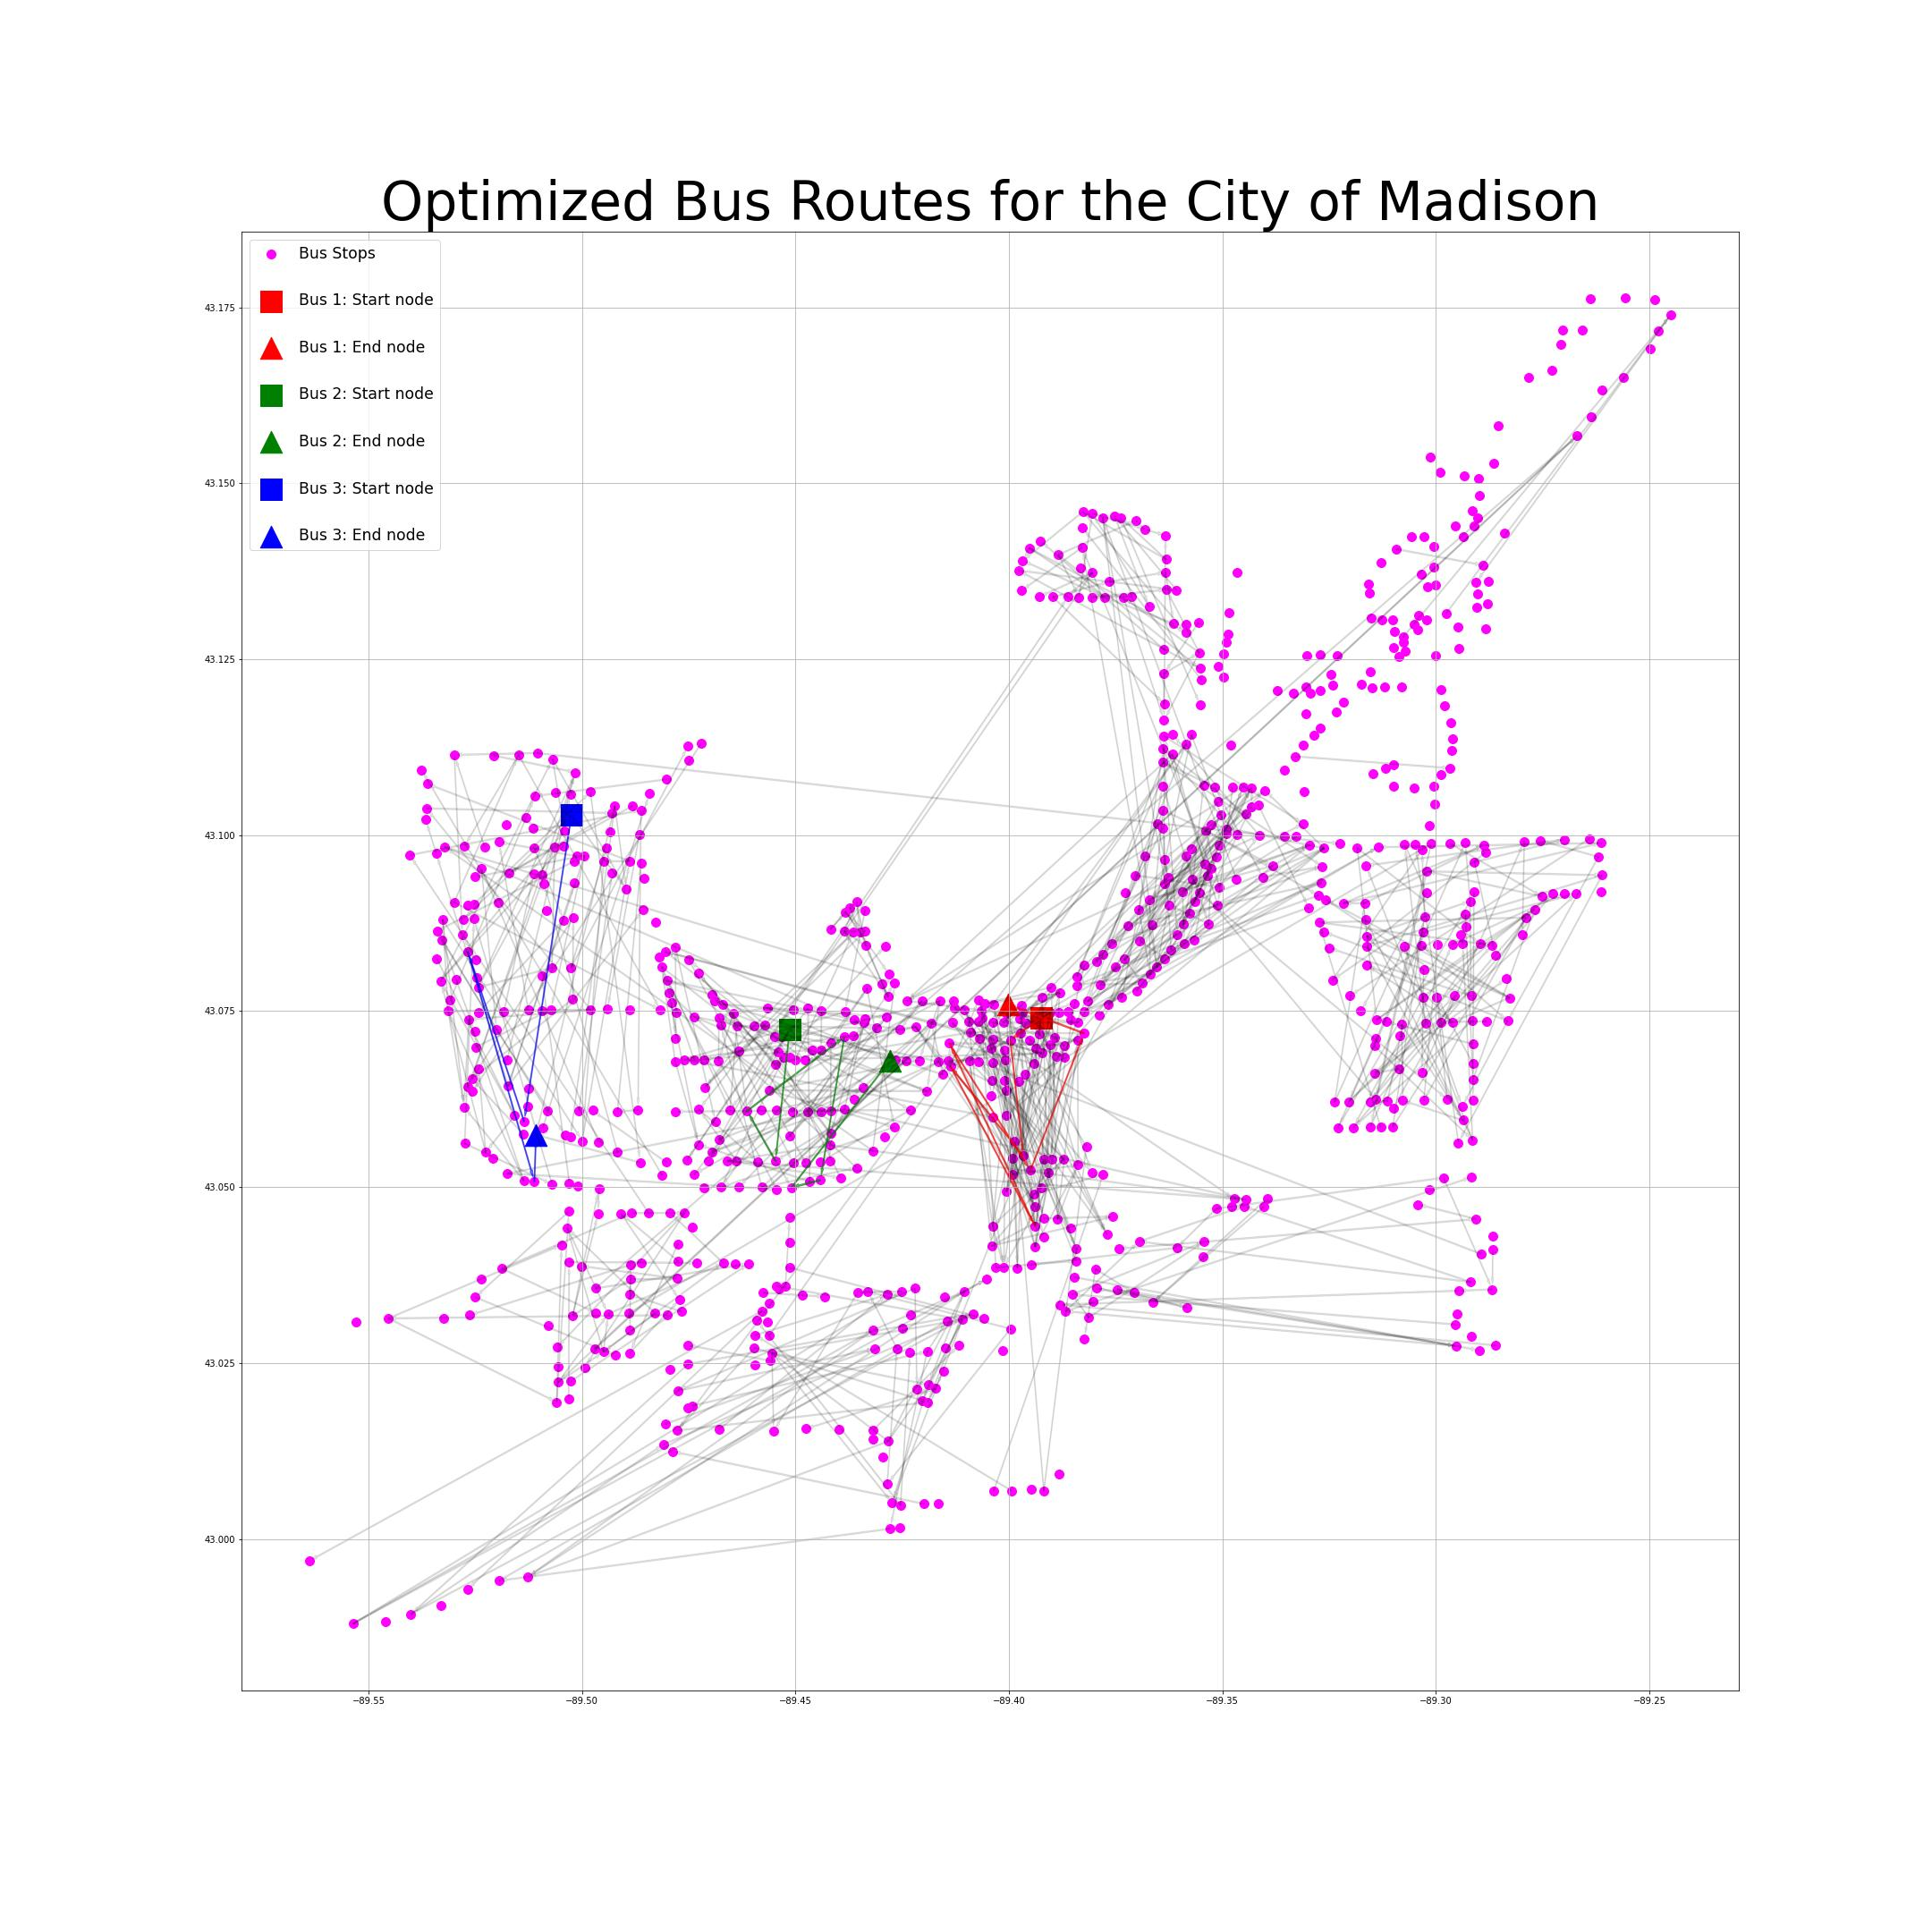

## Further stats:

In [26]:
travelled_nodes = []
for i in 1:num_buses
    println("Bus Stops traversed by Bus "*string(i)*":")
    println(nodes_travelled(opt_path, i))
    println("Fuel used: ", dot(d_e, opt_path[:, i]))
    println("People picked up: ", 12*(dot(r_e, opt_path[:, i]) + r[n_i[i]])) 
    println()
    println()
end

Bus Stops traversed by Bus 1:
[14.0, 9.0, 45.0, 47.0, 84.0, 1.0, 36.0, 69.0]
Fuel used: 1778.2798458938948
People picked up: 495.8400000000001


Bus Stops traversed by Bus 2:
[229.0, 201.0, 276.0, 294.0, 245.0, 225.0]
Fuel used: 1516.5963608963107
People picked up: 263.4


Bus Stops traversed by Bus 3:
[600.0, 608.0, 521.0, 586.0]
Fuel used: 901.2120730600853
People picked up: 374.03999999999996




-----